In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

def cv2_imshow(img):
    h = plt.imshow(img)
    return h


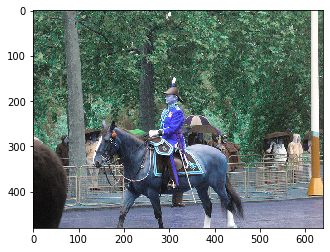

In [3]:
# !wget http://images.cocodataset.org/val2017/000000439715.jpg -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)


In [9]:
DETECTRON_MODEL_ZOO = os.path.expanduser('~/data/models/detectron_model_zoo')
assert os.path.isdir(DETECTRON_MODEL_ZOO)
import subprocess

def download_detectron_model_to_local_zoo(relpath):
    if relpath.startswith('detectron2://'):
        relpath.replace('detectron2://', '', 1)
    url = 'https://dl.fbaipublicfiles.com/detectron2/' + relpath
    outpath = os.path.join(DETECTRON_MODEL_ZOO, relpath)
    outdir = os.path.dirname(outpath)
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    assert os.path.isdir(outdir)
    if os.path.exists(outpath):
        return outpath
    try:
        stdout, stderr = subprocess.check_call(['wget', url, '-O', outpath])
    except CalledProcessError:
        print(stderr)
        raise
    return outpath


DETECTRON_REPO = './detectron2_repo'
cfg = get_cfg()
cfg.merge_from_file(f"{DETECTRON_REPO}/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can either use the https://dl.fbaipublicfiles.... url, or use the following shorthand
model_rel_path = 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl'
local_path = download_detectron_model_to_local_zoo(model_rel_path)
cfg.MODEL.WEIGHTS = local_path
predictor = DefaultPredictor(cfg)
outputs = predictor(im)


WARNING [01/28 13:08:41 d2.config.compat]: Config './detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [10]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
outputs["instances"].pred_classes
outputs["instances"].pred_boxes


Boxes(tensor([[126.6035, 244.8977, 459.8291, 480.0000],
        [251.1083, 157.8127, 338.9731, 413.6379],
        [114.8496, 268.6864, 148.2352, 398.8111],
        [  0.8217, 281.0327,  78.6072, 478.4210],
        [ 49.3953, 274.1229,  80.1545, 342.9808],
        [561.2248, 271.5816, 596.2755, 385.2552],
        [385.9072, 270.3125, 413.7130, 304.0397],
        [515.9295, 278.3744, 562.2792, 389.3802],
        [335.2409, 251.9167, 414.7491, 275.9375],
        [350.9300, 269.2060, 386.0984, 297.9081],
        [331.6292, 230.9996, 393.2759, 257.2009],
        [510.7349, 263.2656, 570.9865, 295.9194],
        [409.0841, 271.8646, 460.5582, 356.8722],
        [506.8766, 283.3257, 529.9404, 324.0392],
        [594.5663, 283.4820, 609.0577, 311.4124]], device='cuda:0'))

In [14]:
from detectron2.engine import DefaultTrainer
print('CFG: ')
print(cfg)
assert len(cfg.DATASETS.TRAIN) == 1

train_data_loader = DefaultTrainer.build_test_loader(cfg, cfg.DATASETS.TRAIN[0])
val_data_loader = DefaultTrainer.build_test_loader(cfg, cfg.DATASETS.TEST[0])  # TEST == 'coco_2017_val'
print('Number of training images: ', len(train_data_loader))
print('Number of validation images: ', len(val_data_loader))

CFG: 
CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('coco_2017_val',)
  TRAIN: ('coco_2017_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 'res3', 'res4', 'res5']
    NORM: 
 

[01/28 13:10:11 d2.data.build]: Distribution of training instances among all 80 categories:
|   category    | #instances   |   category   | #instances   |   category    | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-------------:|:-------------|
|    person     | 10777        |   bicycle    | 314          |      car      | 1918         |
|  motorcycle   | 367          |   airplane   | 143          |      bus      | 283          |
|     train     | 190          |    truck     | 414          |     boat      | 424          |
| traffic light | 634          | fire hydrant | 101          |   stop sign   | 75           |
| parking meter | 60           |    bench     | 411          |     bird      | 427          |
|      cat      | 202          |     dog      | 218          |     horse     | 272          |
|     sheep     | 354          |     cow      | 372          |   elephant    | 252          |
|     bear      | 71           |    zebra     | 266          |

In [28]:
from export_proposal_helpers import just_inference_on_dataset
results = just_inference_on_dataset(predictor.model, train_data_loader, 10)


0 / 118287
1 / 118287
2 / 118287
3 / 118287
4 / 118287
5 / 118287
6 / 118287
7 / 118287
8 / 118287
9 / 118287
10 / 118287


In [44]:
print(len(results))
for r in results:
    print(r['instances'].pred_boxes)
    print(r['instances'].pred_classes)
    print(r['instances'].pred_masks)

1
Boxes(tensor([[146.1715,  89.8196, 424.5707, 630.0513],
        [ 47.6771, 138.4370, 269.3411, 640.0000]], device='cuda:0'))
tensor([23, 23], device='cuda:0')
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')


In [ ]:

example_img = datapoint['image']
data_name = os.path.splitext(os.path.basename(datapoint['file_name']))[0]
from detectron2.structures.instances import Instances
v = Visualizer(example_img, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])
exporter.export_gcf('test image')


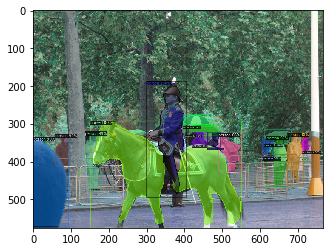

In [6]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
cfg.MODEL.WEIGHTS = "detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl"
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(v.get_image()[:, :, ::-1])
